### ASTROINFORMATICS
https://github.com/astromundus/astroinfo2018


# Week 9-2: Supervised Classification


##### Resources for this notebook include:
- [Textbook](chap9.pdf) Chapter 9.  
 
- code taken and modified from 
[astroML fig. 9.18](http://www.astroml.org/book_figures/chapter9/fig_star_quasar_ROC.html) 



## Classification of LINEAR variables

Let's apply a number of classification methods to 4-D data for periodic
variable stars from the SDSS and LINEAR surveys:

-- SDSS u-g and g-i colors, 

-- LINEAR variability period (logP) and variability amplitude (A).

For more details, see Homeworks 1 and 8 - this is the same data sample.  

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from astroML.decorators import pickle_results
from astroML.datasets import fetch_LINEAR_geneva
from astroML.utils import split_samples
from astroML.classification import GMMBayes  # will become deprecated soon
#from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
# Fetch data and extract the desired quantities
data = fetch_LINEAR_geneva()
# this is a 7-dimensional dataset
attributes = [('gi', 'logP', 'ug', 'iK', 'JK', 'amp', 'skew')]
ug = data['ug']
gi = data['gi']
logP = data['logP']
amp = data['amp'] 
skew = data['skew'] 
labels = data['LCtype']
labels[labels == 6] = 3

In [3]:
Ndata = np.size(labels)
symbcolor = [''] * Ndata
symbcolor = np.where((labels == 1), 'red', symbcolor)
symbcolor = np.where((labels == 2), 'blue', symbcolor)
symbcolor = np.where((labels == 3), 'magenta', symbcolor)
symbcolor = np.where((labels == 4), 'green', symbcolor)
symbcolor = np.where((labels == 5), 'yellow', symbcolor)

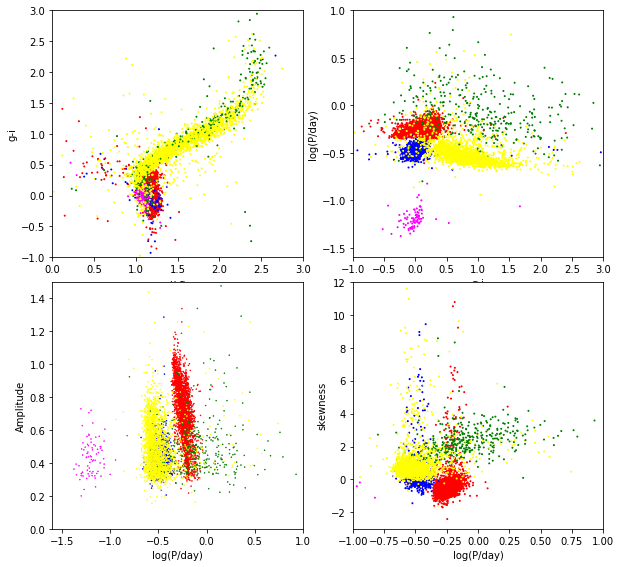

In [4]:
# Plot classes 
fig = plt.figure(figsize=(9, 9))
fig.subplots_adjust(hspace=0.1, left=0.1, right=0.95, bottom=0.1, top=0.9)

ax = fig.add_subplot(221)
xmin, xmax = (0.0, 3.0)
ymin, ymax = (-1.0, 3.0)
ax.scatter(ug, gi, s=1, lw=1.0, c=symbcolor)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xlabel('u-g')
ax.set_ylabel('g-i')

ax = fig.add_subplot(222)
xmin, xmax = (-1.0, 3.0)
ymin, ymax = (-1.6, 1.0)
ax.scatter(gi, logP, s=1, lw=1.0, c=symbcolor)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xlabel('g-i')
ax.set_ylabel('log(P/day)')

ax = fig.add_subplot(223)
xmin, xmax = (-1.6, 1.0)
ymin, ymax = (0.0, 1.5)
ax.scatter(logP, amp, s=1, lw=0.5, c=symbcolor)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xlabel('log(P/day)')
ax.set_ylabel('Amplitude')

ax = fig.add_subplot(224)
xmin, xmax = (-1.0, 1.0)
ymin, ymax = (-3, 12.0)
ax.scatter(logP, skew, s=1, lw=1.0, c=symbcolor)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xlabel('log(P/day)')
ax.set_ylabel('skewness')

plt.show()

In [5]:
Ndim = 4
X = np.empty((Ndata, Ndim), dtype=float)
X[:Ndata, 0] = ug
X[:Ndata, 1] = gi
if (Ndim > 2):
    X[:Ndata, 2] = logP
    X[:Ndata, 3] = amp

y = np.zeros(Ndata, dtype=int)
y[:Ndata] = labels

## RR Lyrae vs. other types: 
# set ab and c type RR Lyrae to 1, other to 0
y[y == 2] = 1
y[y != 1] = 0

# split into training and test sets
(X_train, X_test), (y_train, y_test) = split_samples(X, y, [0.9, 0.1], random_state=0) 

In [9]:
# Compute fits for all the classifiers
def compute_results(*args):
    names = []
    probs = []

    for classifier, kwargs in args:
        print(classifier.__name__)
        model = classifier(**kwargs)
        # note that are using here the training subsample
        model.fit(X_train, y_train)
        # and here evaluating class using the testing subsample 
        print(X_test)
        y_prob = model.predict_proba(X_test)
        print('sss')
        names.append(classifier.__name__)
        probs.append(y_prob[:, 1])

    return names, probs

LRclass_weight = dict([(i, np.sum(y_train == i)) for i in (0, 1)])

names, probs = compute_results((GaussianNB, {}),
                               (KNeighborsClassifier,
                                dict(n_neighbors=10)),
                               (DecisionTreeClassifier,
                                dict(random_state=0, max_depth=12,
                                     criterion='entropy')),
                               (GMMBayes, dict(n_components=3)))

GaussianNB
[[ 1.145      0.341     -0.1727432  0.708    ]
 [ 1.155      0.351     -0.1513669  0.648    ]
 [ 2.334      2.224     -0.3718717  0.44     ]
 ..., 
 [ 1.172      0.292     -0.2735924  0.713    ]
 [ 1.234      0.291     -0.1550496  0.519    ]
 [ 1.         0.183     -0.196674   0.377    ]]
axx0= None
axx= None
[  1.83781046e+00   1.68082831e+00  -9.12803248e+00  -3.02179066e+00
  -3.04351395e+00  -2.87879517e+00   4.37068055e-01  -1.97821127e+00
   1.36863675e+00   1.52874481e+00  -3.53364590e+00   2.18512856e+00
   1.55088767e+00   1.03360377e+00  -4.35671287e+00   2.52365558e+00
   2.47743418e+00  -2.94936177e+00  -6.22676222e-01   1.87970407e+00
  -9.31429228e-01  -2.78877425e+00   4.26944549e-01   2.11149151e+00
  -3.49457019e+00   2.16572588e-01  -1.31357879e+00  -6.33068654e+00
   7.44141946e-01  -2.93216601e+00   6.30841243e-01   1.95895804e+00
   2.14719853e+00   2.28039913e+00   2.47304429e+00  -3.45543190e+00
  -1.21311299e+01   2.05349631e+00   4.01790322e-02  -2.9

['GaussianNB', 'KNeighborsClassifier', 'DecisionTreeClassifier', 'GMMBayes']
1 1
(615,) (615,)
1 1
(615,) (615,)
1 1
(615,) (615,)
1 1
(615,) (1,)


ValueError: Found input variables with inconsistent numbers of samples: [615, 1]

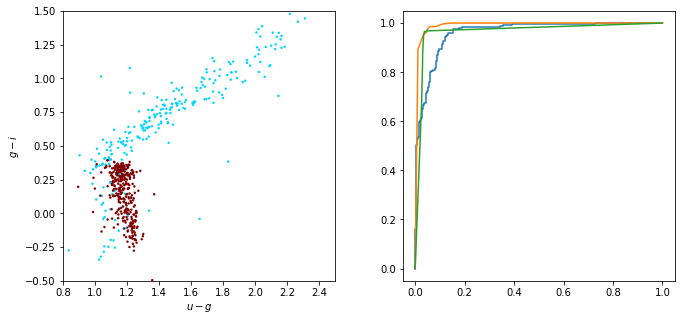

In [14]:
# Plot results
fig = plt.figure(figsize=(10, 5))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15, top=0.9, wspace=0.25)

# First axis shows the data
ax1 = fig.add_subplot(121)
im = ax1.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=6,
                 linewidths=0, edgecolors='none',
                 cmap=plt.cm.jet)
#ax1.set_xlim(0.8, 1.5)
#ax1.set_ylim(-0.5, 0.9)
ax1.set_xlim(0.8, 2.5)
ax1.set_ylim(-0.5, 1.5)
im.set_clim(-0.5, 1)
ax1.set_xlabel('$u - g$')
ax1.set_ylabel('$g - i$')

labels = dict(GaussianNB='GNB',
              KNeighborsClassifier='KNN',
              DecisionTreeClassifier='DT',
              GMMBayes='GMMB')

# Second axis shows the ROC curves
ax2 = fig.add_subplot(122)
print (names)
for name, y_prob in zip(names, probs):
    print (y_test.ndim, y_prob.ndim)
    print (y_test.shape, y_prob.shape)
    
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])
    ax2.plot(fpr, tpr, label=labels[name])

ax2.legend(loc=4)
ax2.set_xlabel('false positive rate')
ax2.set_ylabel('true positive rate')
ax2.set_xlim(0, 0.3)
ax2.set_ylim(0.0, 1.1)
ax2.xaxis.set_major_locator(plt.MaxNLocator(5))

plt.show()